In [60]:
import numpy as np
import pandas as pd
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

In [61]:
def early_prediction_score(y_true, y_pred, alpha=0.5):
    errors = y_pred - y_true
    # Heavier penalty for late predictions
    weights = np.where(errors < 0, alpha, 1)
    return np.mean(weights * errors**2)

In [83]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        # '1_4',
        # '1_5',
        # '1_6',
        # '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [63]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:33<00:00, 417.85it/s]
INFO:root:Read in 53.69208359718323 seconds


In [64]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [65]:
df[0].head(5)

,V_acc,unit,H_acc,rul
0,-0.146,1_1,0.552,28029
1,-0.480,1_1,0.501,28029
2,0.435,1_1,0.138,28029
3,0.240,1_1,-0.423,28029
4,0.020,1_1,-0.802,28029


In [66]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [67]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
2229755    1_2
2229756    1_2
2229757    1_2
2229758    1_2
2229759    1_2
Name: unit, Length: 9405440, dtype: object

In [68]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,V_acc,unit,H_acc,rul
0,-0.146,1_1,0.552,28029
1,-0.480,1_1,0.501,28029
2,0.435,1_1,0.138,28029
3,0.240,1_1,-0.423,28029
4,0.020,1_1,-0.802,28029
...,...,...,...,...
2229755,3.622,1_2,-2.595,0
2229756,8.675,1_2,-2.869,0
2229757,8.111,1_2,1.457,0
2229758,1.403,1_2,1.591,0


In [69]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,V_acc,unit,H_acc,rul
0,0.044,1_3,0.092,23749
1,0.432,1_3,-0.025,23749
2,0.008,1_3,-0.104,23749
3,-0.264,1_3,0.056,23749
4,-0.195,1_3,0.074,23749
...,...,...,...,...
3845115,-0.013,1_7,0.481,7570
3845116,-0.272,1_7,0.191,7570
3845117,0.466,1_7,0.250,7570
3845118,-0.582,1_7,0.001,7570


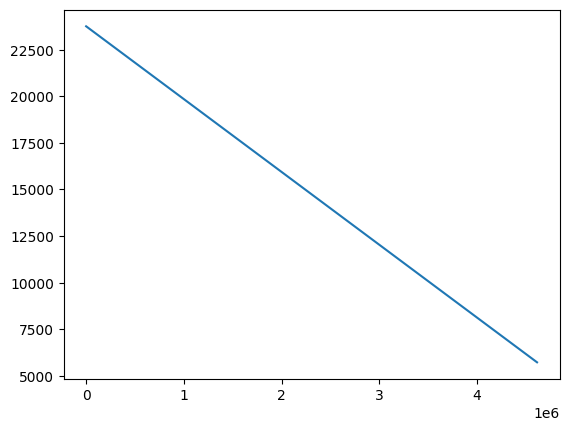

In [92]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

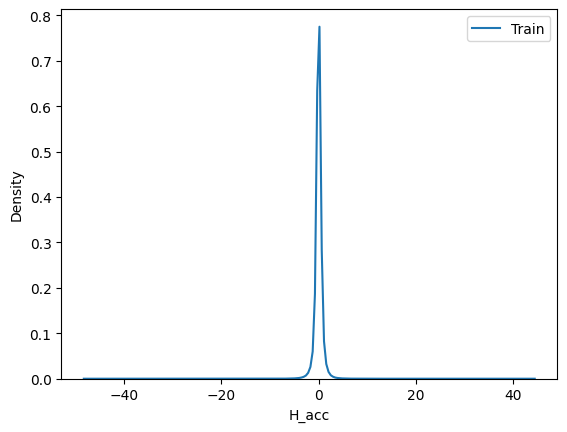

In [70]:
sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
plt.legend(); plt.show()

In [111]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=512, step=64):
        self.windows = []
        self.ruls = []
        
        vib_h = df['H_acc'].values
        vib_v = df['V_acc'].values
        rul = df['rul'].values
        max_rul = max(rul)
        
        # Normalize per bearing
        vib_h = (vib_h - vib_h.mean()) / (vib_h.std() + 1e-8)
        vib_v = (vib_v - vib_v.mean()) / (vib_v.std() + 1e-8)
        
        # Create sequences
        for i in range(0, len(df) - window_size, step):
            self.windows.append(np.stack([vib_h[i:i+window_size], 
                                        vib_v[i:i+window_size]], axis=1))
            self.ruls.append(rul[i+window_size] / max_rul)

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    df=df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'].isin(TEST_BEARINGS[1])],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [116]:
test_dataset[-3][1]

tensor([0.2413])

In [72]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv1d(2, 64, kernel_size=50, padding=24),  # (B, 2, 512) -> (B, 64, 512)
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),  # -> (B, 64, 256)
            
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),  # -> (B, 128, 128)
            
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2)   # -> (B, 256, 64)
        )
        
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256*64, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 512, 2) -> (B, 2, 512)
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.regressor(x).squeeze()

model = BearingCNN()
print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(50,), stride=(1,), padding=(24,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    model.train()

    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    # requires too much memory
    # Reference: MemoryError: Unable to allocate 80.4 GiB for an array with shape (146952, 146952) and data type float32
    # train_eps = []
    train_loss = []

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        # epoch_train_eps = early_prediction_score(train_targets, train_preds)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        # train_eps.append(epoch_train_eps)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        # 'train_eps': train_eps,
    }

In [74]:
train_results = train(model, train_loader, optimizer, criterion, device, 5)

train_results

  0%|          | 0/4593 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 4583/4593 [00:31<00:00, 133.43it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4593/4593 [00:31<00:00, 146.21it/s]


Epoch 0: Train Loss 0.2094, Train R2 = -1.408, Train RMSE = 0.458, Train MSE = 0.209, Train MAE = 0.104


  0%|          | 0/4593 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 4591/4593 [00:33<00:00, 129.76it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4593/4593 [00:33<00:00, 137.29it/s]


Epoch 1: Train Loss 0.0198, Train R2 = 0.772, Train RMSE = 0.141, Train MSE = 0.020, Train MAE = 0.066


  0%|          | 0/4593 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 4582/4593 [00:35<00:00, 124.46it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4593/4593 [00:35<00:00, 128.02it/s]


Epoch 2: Train Loss 0.0168, Train R2 = 0.807, Train RMSE = 0.130, Train MSE = 0.017, Train MAE = 0.049


  0%|          | 0/4593 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 4591/4593 [00:38<00:00, 118.12it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4593/4593 [00:38<00:00, 118.73it/s]


Epoch 3: Train Loss 0.0067, Train R2 = 0.923, Train RMSE = 0.082, Train MSE = 0.007, Train MAE = 0.037


  0%|          | 0/4593 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 4589/4593 [00:39<00:00, 119.07it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4593/4593 [00:39<00:00, 116.72it/s]


Epoch 4: Train Loss 0.0033, Train R2 = 0.962, Train RMSE = 0.057, Train MSE = 0.003, Train MAE = 0.027


{'train_loss': [0.20936987481729152,
  0.019798899731732347,
  0.01678410072659994,
  0.006673135049716647,
  0.0032853872305908718],
 'train_r2': [-1.4080647123552952,
  0.7722831524784389,
  0.8069591254126354,
  0.9232497518820229,
  0.9622084240221652],
 'train_mae': [0.10401288, 0.065616526, 0.04885619, 0.036872424, 0.026813107],
 'train_mse': [0.20940372, 0.019802105, 0.016786704, 0.00667415, 0.0032863303],
 'train_rmse': [0.45760652, 0.14071995, 0.12956351, 0.081695475, 0.05732652]}

In [129]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



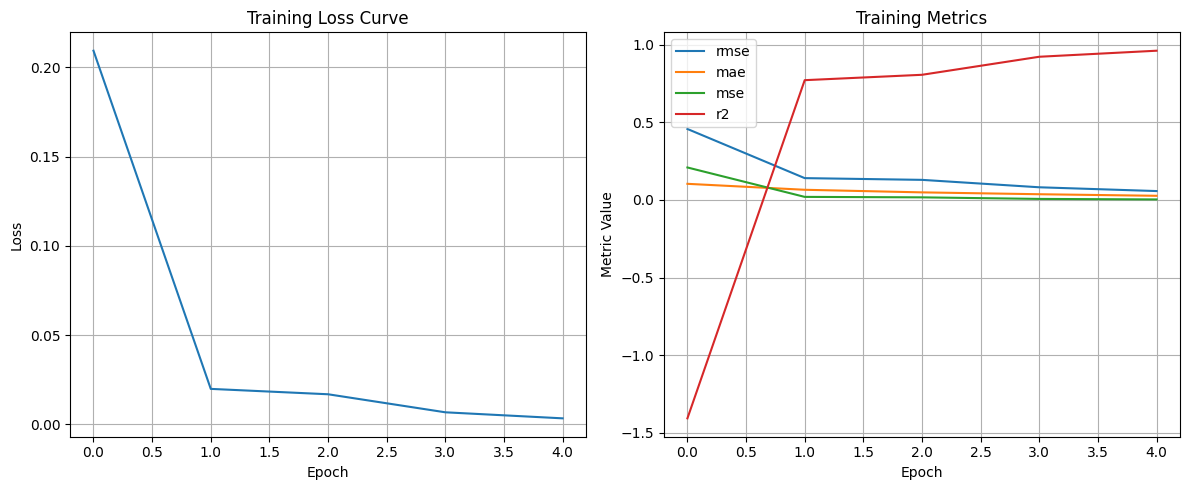

In [76]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [126]:
def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    # test_eps = []

    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)

            predictions = model(data).flatten()

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))
        # test_eps.append(early_prediction_score(test_targets, test_preds))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
        # 'test_eps': test_eps,
    }
          

In [127]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 2253/2253 [00:03<00:00, 657.48it/s]


{'test_r2': [-7.999834162287151],
 'test_mae': [0.62067235],
 'test_mse': [0.43169376],
 'test_rmse': [0.65703404],
 'test_preds': array([ 0.00388728,  0.00180692,  0.00317246, ..., -0.01007059,
        -0.01550672, -0.01027524], dtype=float32),
 'test_targets': array([[0.9999158 ],
        [0.9999158 ],
        [0.9999158 ],
        ...,
        [0.24127331],
        [0.24127331],
        [0.24127331]], dtype=float32)}

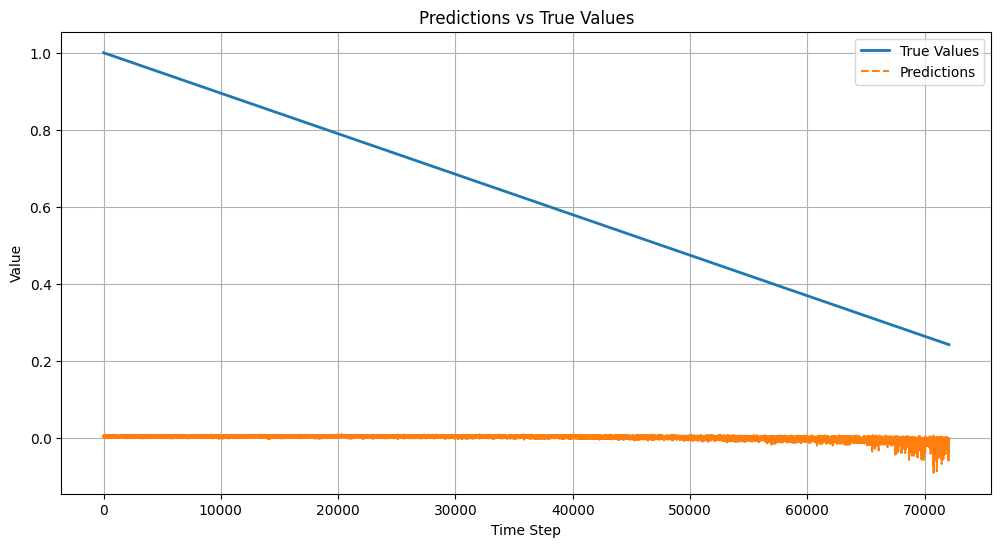

In [130]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds']
)

In [125]:
test_results['test_targets']

array([ 0.00388728,  0.00180692,  0.00317246, ..., -0.01007059,
       -0.01550672, -0.01027524], dtype=float32)